In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import numpy as np
from sklearn.cluster import HDBSCAN
from tqdm import tqdm
# from lib.dataloader import CustomTestDataset
import tifffile as tiff
import os
from sklearn.cluster import KMeans

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dist_metric = ['cosine']

num_clusters = 4
patch_size = (64,64)
mask_size = 1
label_size = 1
n_channel = 32
hierarchy_level = 3
model_versions = ['5x5_5x5', '5x5_3x3', '5x5_1x1', '3x3_3x3', '3x3_1x1', '1x1_1x1']

In [3]:
data_dir = "/group/jug/Sheida/pancreatic beta cells/download/"

One_test_image = ['high_c4']

# Load test image
test_img_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_source.tif")
test_images = tiff.imread(test_img_path)

# Print loaded test images paths
print("Test image loaded from path:")
print(test_img_path)

# Load test ground truth images
test_gt_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_gt.tif")
test_ground_truth_image = tiff.imread(test_gt_path)

Test image loaded from path:
/group/jug/Sheida/pancreatic beta cells/download/high_c4/high_c4_source.tif


In [4]:
def count_label_pixels(ground_truth):
    # Get unique labels and their counts
    unique_labels, counts = np.unique(ground_truth, return_counts=True)
    
    # Create a dictionary to store label-wise pixel counts
    label_pixel_counts = dict(zip(unique_labels, counts))
    
    return label_pixel_counts

In [5]:
label_pixel_counts = count_label_pixels(test_ground_truth_image)
print(f"Label-wise pixel counts:{label_pixel_counts}")

Label-wise pixel counts:{-1: 409001638, 0: 107710351, 1: 25910981, 2: 36936035, 3: 23104175}


In [6]:
def select_random_pixels_within_range(ground_truth, labels, pixels_per_class, x_range, y_range, z_range):
    selected_pixels = {}

    for label in labels:
        # Get the coordinates where ground truth equals the label
        coords = np.argwhere(ground_truth == label)
        
        # Filter coordinates based on the specified range
        x_in_range = (coords[:, 2] >= x_range[0]) & (coords[:, 2] <= x_range[1])
        y_in_range = (coords[:, 1] >= y_range[0]) & (coords[:, 1] <= y_range[1])
        z_in_range = (coords[:, 0] >= z_range[0]) & (coords[:, 0] <= z_range[1])
        
        # Keep only the coordinates that satisfy all range conditions
        filtered_coords = coords[z_in_range & y_in_range & x_in_range]
        
        # Check if there are enough pixels for the current label after filtering
        if len(filtered_coords) < pixels_per_class:
            raise ValueError(f"Not enough pixels for label {label} within the specified range. Found {len(filtered_coords)}, required {pixels_per_class}")
        
        # Randomly select pixels_per_class coordinates from filtered_coords
        chosen_indices = np.random.choice(len(filtered_coords), pixels_per_class, replace=False)
        chosen_coords = filtered_coords[chosen_indices]
        
        # Store selected coordinates for the label
        selected_pixels[label] = chosen_coords

    return selected_pixels


In [7]:
labels_of_interest = [0, 1, 2, 3]
z, y, x = test_images.shape
x_range = (32, x - 32)
y_range = (32, y - 32)
z_range = (0, z - 1)

In [8]:
# selected_pixel_coords = select_random_pixels_within_range(test_ground_truth_image, labels_of_interest, pixels_per_class=256, x_range=x_range, y_range=y_range, z_range=z_range)

In [9]:
import pickle

def save_as_pickle(selected_pixel_coords, filename):
    with open(filename, 'wb') as f:
        pickle.dump(selected_pixel_coords, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    return data
# Usage
# save_as_pickle(selected_pixel_coords, 'selected_pixel_coords.pkl')
selected_pixel_coords = load_pickle('selected_pixel_coords.pkl')

In [10]:
for label, coords in selected_pixel_coords.items():
    print(f"Label {label}: {coords}")

Label 0: [[ 753  217  399]
 [ 588  418  440]
 [ 446   76  810]
 [ 344  307  929]
 [ 574  228  687]
 [ 688  442  985]
 [ 848  394  464]
 [ 575  194  302]
 [ 659  308  186]
 [ 883  404  615]
 [ 314  423  471]
 [ 374   99  670]
 [ 839  315  877]
 [ 714  286   99]
 [ 676  102  617]
 [ 550  417  389]
 [ 760  330  623]
 [ 606  436  479]
 [ 654  173  720]
 [ 315  137  447]
 [ 372  247  897]
 [ 686  218  731]
 [ 833  285   97]
 [ 403  151  414]
 [ 805  221  570]
 [ 481  500  541]
 [ 525  167  625]
 [ 835  394  559]
 [ 196  228  897]
 [ 737  300  730]
 [ 438  191  944]
 [ 589  363  427]
 [ 490  244  887]
 [ 363  255  241]
 [ 651  435  277]
 [ 796  203  277]
 [ 785  194  441]
 [ 208  155 1011]
 [ 472  175  630]
 [ 339  232  470]
 [ 429  204  954]
 [ 893  390  407]
 [ 756  229  682]
 [ 325  285  371]
 [ 272  351  950]
 [ 860  343  878]
 [ 584  170  820]
 [ 466  238  737]
 [ 857  254  149]
 [ 330  360  852]
 [ 780  264  537]
 [ 539  380  408]
 [ 548  135  785]
 [ 410   85  695]
 [ 726  262  153]
 

In [11]:
def extract_patches(image, coords, patch_size=(64,64)):
    half_size_y = patch_size[0] // 2
    half_size_x = patch_size[1] // 2
    patches = []

    # Get the shape of the image
    _, y_max, x_max = image.shape

    for coord in coords:
        z, y, x = coord

        # Calculate the boundaries of the patch
        x_start = max(0, x - half_size_x)
        x_end = min(x_max, x + half_size_x)
        y_start = max(0, y - half_size_y)
        y_end = min(y_max, y + half_size_y)

        
        # Extract the patch from the image
        patch = image[z, y_start:y_end, x_start:x_end]
        
        # Check if the patch is the required size, otherwise pad with zeros
        if patch.shape != patch_size:
            print("something is wrong")

        
        # Store the patch
        patches.append(patch)

    return np.array(patches)

In [12]:
all_patches_tensors = []

for label, coords in selected_pixel_coords.items():
    patches = extract_patches(test_images, coords, patch_size=patch_size)
    patches_tensor = torch.tensor(patches, dtype=torch.float32).unsqueeze(1)
    print(f"Patches for label {label}: {patches_tensor.shape}")  # The shape should be (256, 64, 64)
    all_patches_tensors.append(patches_tensor)

combined_tensor = torch.stack(all_patches_tensors, dim=0).reshape(8, 128, 1, 64, 64)
print(combined_tensor.shape)

Patches for label 0: torch.Size([256, 1, 64, 64])
Patches for label 1: torch.Size([256, 1, 64, 64])
Patches for label 2: torch.Size([256, 1, 64, 64])
Patches for label 3: torch.Size([256, 1, 64, 64])
torch.Size([8, 128, 1, 64, 64])


In [13]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'supervised_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}supervised_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.30it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


In [14]:
seg = []
for i in range(len(model_versions)):
    seg.append(tiff.imread(f"{model_dir}supervised_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(seg[i][j]))

{1: 9, 2: 245, 3: 2}
{0: 242, 2: 14}
{1: 164, 2: 92}
{1: 2, 2: 136, 3: 118}
{0: 1, 1: 10, 2: 243, 3: 2}
{0: 248, 2: 8}
{1: 203, 2: 51, 3: 2}
{1: 4, 2: 118, 3: 134}
{0: 4, 1: 16, 2: 214, 3: 22}
{0: 253, 2: 3}
{1: 197, 2: 57, 3: 2}
{1: 2, 2: 89, 3: 165}
{1: 236, 2: 13, 3: 7}
{0: 241, 1: 15}
{0: 1, 1: 56, 2: 197, 3: 2}
{1: 108, 2: 2, 3: 146}
{1: 229, 2: 19, 3: 8}
{0: 243, 1: 12, 3: 1}
{1: 45, 2: 208, 3: 3}
{1: 140, 2: 2, 3: 114}
{0: 3, 1: 231, 2: 13, 3: 9}
{0: 247, 1: 9}
{0: 1, 1: 49, 2: 202, 3: 4}
{0: 1, 1: 73, 2: 6, 3: 176}


In [15]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def compute_dice_coefficient(ground_truth, predicted):
    """
    Compute Dice coefficient between ground truth and predicted segmentation after resolving label permutations.
    
    Args:
    - ground_truth (numpy array): Ground truth labels (values from 0 to 3).
    - predicted (numpy array): Predicted labels (after clustering, might be permuted).
    
    Returns:
    - dice_coefficients (list): Dice coefficients for each class (label).
    """
    # Ensure both arrays are 1D
    ground_truth = ground_truth.flatten()
    predicted = predicted.flatten()
    
    # Create a confusion matrix
    # Rows: Ground truth labels (0 to 3)
    # Columns: Predicted cluster labels (0 to 3, possibly permuted)
    conf_matrix = confusion_matrix(ground_truth, predicted, labels=[0, 1, 2, 3])
    
    # Use the Hungarian algorithm to find the optimal label assignment (best permutation)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)  # Negative because it's maximization problem
    
    # Re-map predicted labels to match ground truth
    remapped_predicted = np.zeros_like(predicted)
    for gt_label, pred_label in zip(row_ind, col_ind):
        remapped_predicted[predicted == pred_label] = gt_label
    
    # Compute Dice coefficient for each class
    dice_coefficients = []
    for label in np.unique(ground_truth):
        gt_binary = (ground_truth == label)
        pred_binary = (remapped_predicted == label)
        
        intersection = np.sum(gt_binary & pred_binary)
        dice = (2. * intersection) / (np.sum(gt_binary) + np.sum(pred_binary))
        dice_coefficients.append(dice)
    
    return dice_coefficients

In [16]:
gt = np.zeros((4, 256), dtype=np.uint8)
gt[0] = 0
gt[1] = 1
gt[2] = 2
gt[3] = 3

In [24]:
for i in range(len(seg)):
    dice_scores = compute_dice_coefficient(gt, seg[i])
    print(dice_scores)

[0.6594885598923284, 0.9718875502008032, 0.7610208816705336, 0.6276595744680851]
[0.7189349112426036, 0.9821782178217822, 0.8583509513742071, 0.6802030456852792]
[0.691437802907916, 0.98635477582846, 0.8365180467091295, 0.7415730337078652]
[0.7034277198211625, 0.9678714859437751, 0.8418803418803419, 0.7104622871046229]
[0.6715542521994134, 0.9739478957915831, 0.8577319587628865, 0.5968586387434555]
[0.7475728155339806, 0.9724409448818898, 0.8469601677148847, 0.7910112359550562]


In [18]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'10p_semi_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}10p_semi_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.43it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


In [19]:
semi_10_seg = []
for i in range(len(model_versions)):
    semi_10_seg.append(tiff.imread(f"{model_dir}10p_semi_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(semi_10_seg[i][j]))

{1: 253, 2: 2, 3: 1}
{0: 228, 1: 28}
{1: 242, 2: 2, 3: 12}
{1: 234, 2: 22}
{0: 1, 1: 237, 2: 12, 3: 6}
{0: 233, 1: 23}
{1: 118, 2: 138}
{1: 182, 2: 2, 3: 72}
{0: 3, 1: 232, 2: 17, 3: 4}
{0: 248, 1: 8}
{1: 92, 2: 163, 3: 1}
{0: 1, 1: 118, 2: 5, 3: 132}
{1: 245, 2: 6, 3: 5}
{0: 209, 1: 47}
{1: 124, 2: 130, 3: 2}
{1: 117, 2: 7, 3: 132}
{1: 232, 2: 11, 3: 13}
{0: 237, 1: 17, 2: 1, 3: 1}
{1: 100, 2: 151, 3: 5}
{1: 129, 2: 4, 3: 123}
{1: 225, 2: 15, 3: 16}
{0: 240, 1: 14, 3: 2}
{1: 79, 2: 171, 3: 6}
{0: 1, 1: 44, 2: 5, 3: 206}


In [25]:
for i in range(len(semi_10_seg)):
    dice_scores = compute_dice_coefficient(gt, semi_10_seg[i])
    print(dice_scores)

[0.49950641658440276, 0.9421487603305785, 0.08921933085501858, 0.15602836879432624]
[0.5808823529411765, 0.9510204081632653, 0.6764705882352942, 0.4311377245508982]
[0.6572237960339944, 0.9763779527559056, 0.7392290249433107, 0.6717557251908397]
[0.6210392902408112, 0.8989247311827957, 0.6516290726817042, 0.6683544303797468]
[0.6321525885558583, 0.9614604462474645, 0.7139479905437353, 0.6180904522613065]
[0.7281553398058253, 0.96579476861167, 0.7651006711409396, 0.8477366255144033]


In [21]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+'1p_semi_'+str(model_v)+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}1p_semi_{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised 5x5_5x5


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 5x5_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


Processing 1024 pixels with model version supervised 5x5_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


Processing 1024 pixels with model version supervised 3x3_3x3


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.39it/s]


Processing 1024 pixels with model version supervised 3x3_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Processing 1024 pixels with model version supervised 1x1_1x1


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


In [22]:
semi_1_seg = []
for i in range(len(model_versions)):
    semi_1_seg.append(tiff.imread(f"{model_dir}1p_semi_{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(semi_1_seg[i][j]))

{1: 246, 2: 9, 3: 1}
{0: 180, 1: 40, 2: 36}
{1: 246, 3: 10}
{0: 8, 1: 228, 2: 18, 3: 2}
{1: 1, 2: 245, 3: 10}
{0: 176, 1: 53, 2: 27}
{2: 230, 3: 26}
{2: 228, 3: 28}
{1: 33, 2: 23, 3: 200}
{0: 201, 1: 8, 2: 16, 3: 31}
{1: 40, 2: 32, 3: 184}
{1: 40, 2: 23, 3: 193}
{0: 3, 1: 11, 2: 232, 3: 10}
{0: 246, 1: 1, 2: 9}
{1: 46, 2: 208, 3: 2}
{0: 3, 1: 9, 2: 180, 3: 64}
{1: 191, 2: 55, 3: 10}
{0: 177, 1: 26, 3: 53}
{1: 169, 2: 86, 3: 1}
{1: 174, 2: 48, 3: 34}
{0: 1, 1: 53, 2: 196, 3: 6}
{0: 212, 2: 40, 3: 4}
{1: 101, 2: 153, 3: 2}
{1: 71, 2: 100, 3: 85}


In [26]:
for i in range(len(semi_1_seg)):
    dice_scores = compute_dice_coefficient(gt, semi_1_seg[i])
    print(dice_scores)

[0.484251968503937, 0.8108108108108109, 0.07434944237918216, 0.11285266457680251]
[0.4969574036511156, 0.8148148148148148, 0.0, 0.175]
[0.46296296296296297, 0.8796498905908097, 0.18285714285714286, 0.21220159151193635]
[0.5242937853107345, 0.968503937007874, 0.2848297213622291, 0.3855421686746988]
[0.4681372549019608, 0.8175519630484989, 0.3865168539325843, 0.192090395480226]
[0.5261744966442953, 0.9040511727078892, 0.41995841995842, 0.48158640226628896]


In [88]:
import matplotlib.pyplot as plt
from math import pi

color_list = [
    '#00CED1',  # Dark Turquoise
    '#3357FF',  # Bright Blue
    '#9400D3',  # Dark Violet
    '#FF8C00',  # Dark Orange
    '#FF5733',  # Vivid Orange-Red
    '#FF00FF',  # Magenta
]

In [89]:
# Function to create radar charts for multiple experiments
def radar_chart(experiments_data, experiment_labels, title):
    
    classes = ['                 Uncategorized', 'Nucleus', 'Granule       ', 'Mitochondria']
    
    # Number of variables (classes in this case)
    num_vars = len(classes)

    # Compute angle of each axis
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Complete the loop

    # Initialize the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each experiment's scores
    for i, experiment_scores in enumerate(experiments_data):
        data = experiment_scores + experiment_scores[:1]  # Complete the loop
        ax.plot(angles, data, linewidth=1, linestyle='dashed', color=color_list[i], label=experiment_labels[i])
        ax.fill(angles, data, color=color_list[i], alpha=0.1)

    # Add the class names as labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)


    # Set the range and labels for the radial grid
    ax.set_rlabel_position(45)  # Position the radial labels at 45 degrees
    ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # Define where the radial ticks appear
    ax.set_yticklabels(['', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0'], fontsize=10, color='#696969' )  # Define the tick labels
    ax.set_ylim(0, 1)  # Ensure the plot goes from 0 to 1

    # Make the outer circle gray and adjust the gridlines color to gray
    ax.spines['polar'].set_visible(True)  # Make sure the outer spine is visible
    ax.spines['polar'].set_color('gray')  # Set the outer circle (spine) color to gray
    ax.spines['polar'].set_linewidth(1)   # Set the line width of the outer circle

        # First extended data: up to 1.5 radius
    extended_data_1 = [1.0] * num_vars  # Extended boundary at radius 1.5
    extended_data_1 += extended_data_1[:1]  # Complete the loop
    ax.fill(angles, extended_data_1, color='green', alpha=0.03)  # Lighter fill for extension

    # Second extended data: up to 2.0 radius
    extended_data_2 = [0.25] * num_vars  # Extended boundary at radius 2.0
    extended_data_2 += extended_data_2[:1]  # Complete the loop
    ax.fill(angles, extended_data_2, color='red', alpha=0.04)  # Even lighter fill for outer extension
    # Add a floating legend
    plt.legend(loc='upper left', bbox_to_anchor=(-0.3, 1.05))  # Move the legend outside the plot

    # Remove plt.title and use ax.text for full customization
    plt.title(r'Comparison of Cluster-wise $\mathbf{Dice\ Scores}$ for Different Experiments - '+title, 
          size=13, color='black', y=1.1)


    # Show the plot
    plt.show()

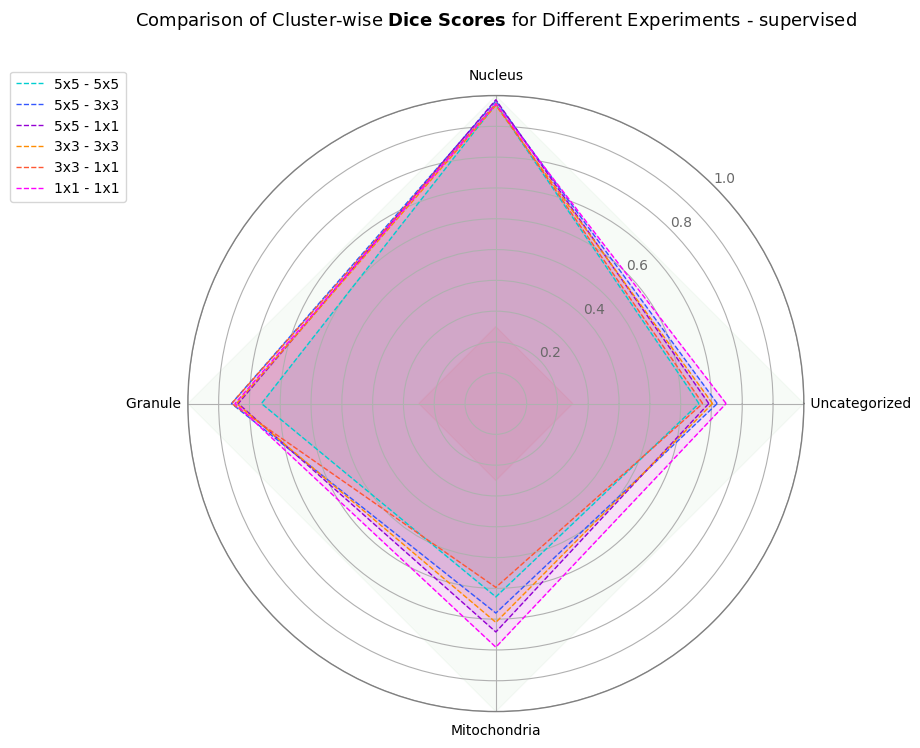

In [90]:
experiments_data = [
[0.6594885598923284, 0.9718875502008032, 0.7610208816705336, 0.6276595744680851],
[0.7189349112426036, 0.9821782178217822, 0.8583509513742071, 0.6802030456852792],
[0.691437802907916, 0.98635477582846, 0.8365180467091295, 0.7415730337078652],
[0.7034277198211625, 0.9678714859437751, 0.8418803418803419, 0.7104622871046229],
[0.6715542521994134, 0.9739478957915831, 0.8577319587628865, 0.5968586387434555],
[0.7475728155339806, 0.9724409448818898, 0.8469601677148847, 0.7910112359550562],
]
experiment_labels = ['5x5 - 5x5', '5x5 - 3x3', '5x5 - 1x1', '3x3 - 3x3', '3x3 - 1x1', '1x1 - 1x1']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'supervised')


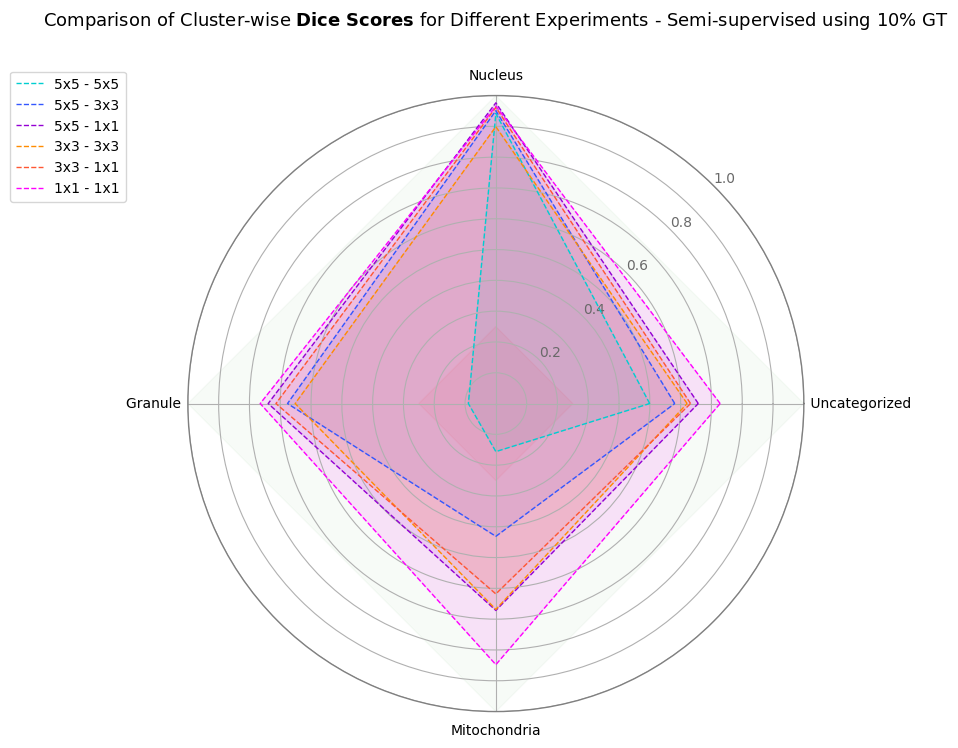

In [91]:
experiments_data = [
[0.49950641658440276, 0.9421487603305785, 0.08921933085501858, 0.15602836879432624],
[0.5808823529411765, 0.9510204081632653, 0.6764705882352942, 0.4311377245508982],
[0.6572237960339944, 0.9763779527559056, 0.7392290249433107, 0.6717557251908397],
[0.6210392902408112, 0.8989247311827957, 0.6516290726817042, 0.6683544303797468],
[0.6321525885558583, 0.9614604462474645, 0.7139479905437353, 0.6180904522613065],
[0.7281553398058253, 0.96579476861167, 0.7651006711409396, 0.8477366255144033],

]
experiment_labels = ['5x5 - 5x5', '5x5 - 3x3', '5x5 - 1x1', '3x3 - 3x3', '3x3 - 1x1', '1x1 - 1x1']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'Semi-supervised using 10% GT')


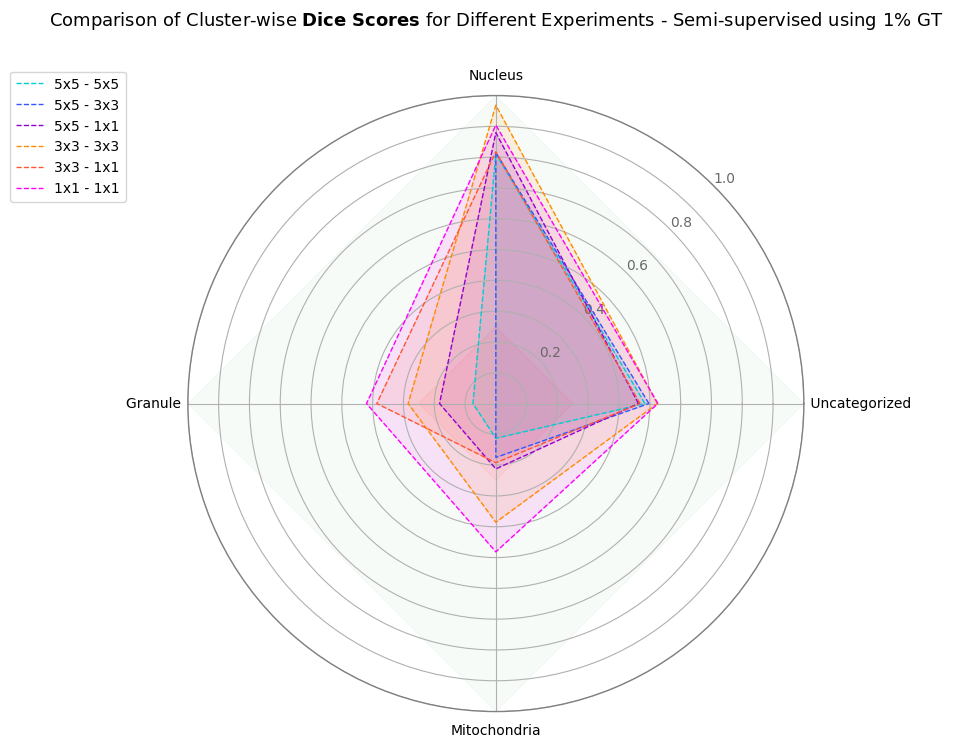

In [92]:
experiments_data = [
[0.484251968503937, 0.8108108108108109, 0.07434944237918216, 0.11285266457680251],
[0.4969574036511156, 0.8148148148148148, 0.0, 0.175],
[0.46296296296296297, 0.8796498905908097, 0.18285714285714286, 0.21220159151193635],
[0.5242937853107345, 0.968503937007874, 0.2848297213622291, 0.3855421686746988],
[0.4681372549019608, 0.8175519630484989, 0.3865168539325843, 0.192090395480226],
[0.5261744966442953, 0.9040511727078892, 0.41995841995842, 0.48158640226628896],
]
experiment_labels = ['5x5 - 5x5', '5x5 - 3x3', '5x5 - 1x1', '3x3 - 3x3', '3x3 - 1x1', '1x1 - 1x1']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'Semi-supervised using 1% GT')


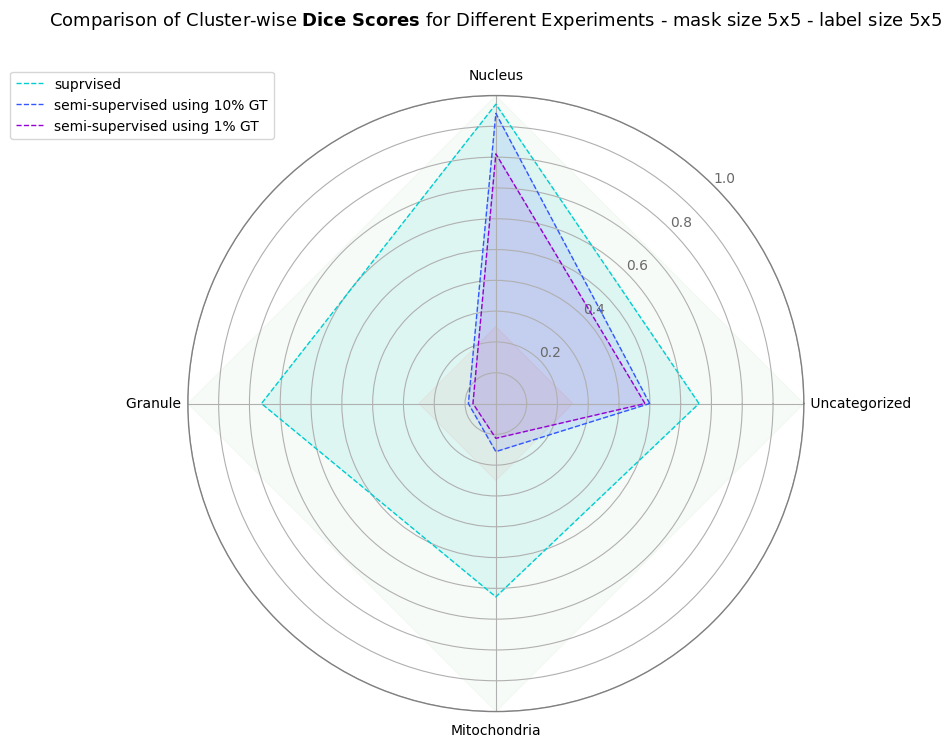

In [99]:
experiments_data = [
[0.6594885598923284, 0.9718875502008032, 0.7610208816705336, 0.6276595744680851],
[0.49950641658440276, 0.9421487603305785, 0.08921933085501858, 0.15602836879432624],
[0.484251968503937, 0.8108108108108109, 0.07434944237918216, 0.11285266457680251],
]
experiment_labels = ['suprvised', 'semi-supervised using 10% GT', 'semi-supervised using 1% GT']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 5x5 - label size 5x5')


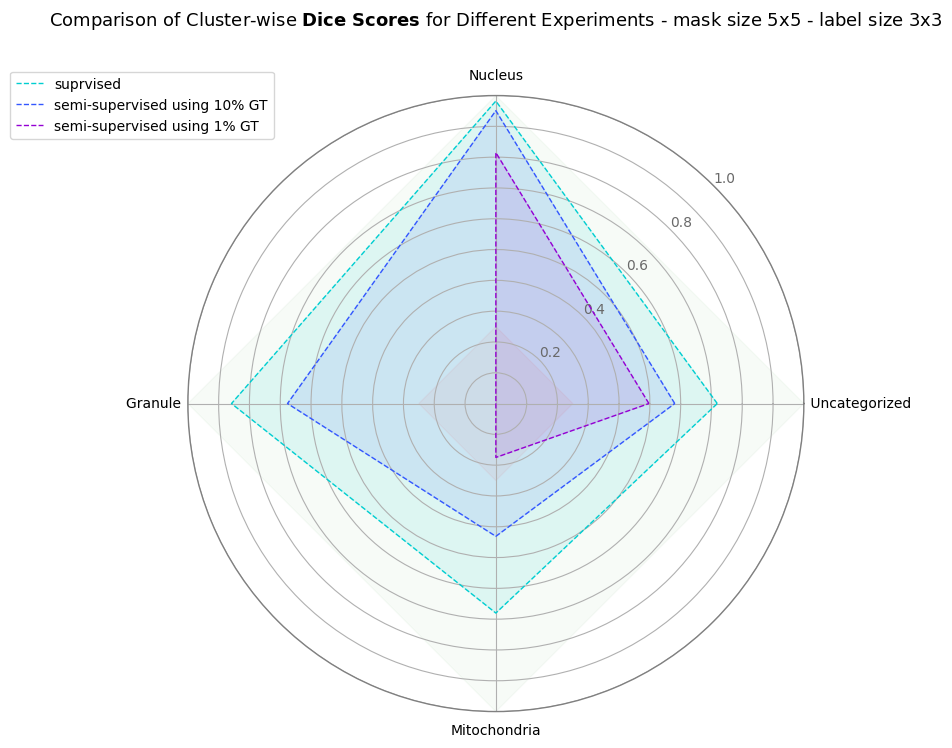

In [98]:
experiments_data = [
[0.7189349112426036, 0.9821782178217822, 0.8583509513742071, 0.6802030456852792],
[0.5808823529411765, 0.9510204081632653, 0.6764705882352942, 0.4311377245508982],
[0.4969574036511156, 0.8148148148148148, 0.0, 0.175],
]
experiment_labels = ['suprvised', 'semi-supervised using 10% GT', 'semi-supervised using 1% GT']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 5x5 - label size 3x3')


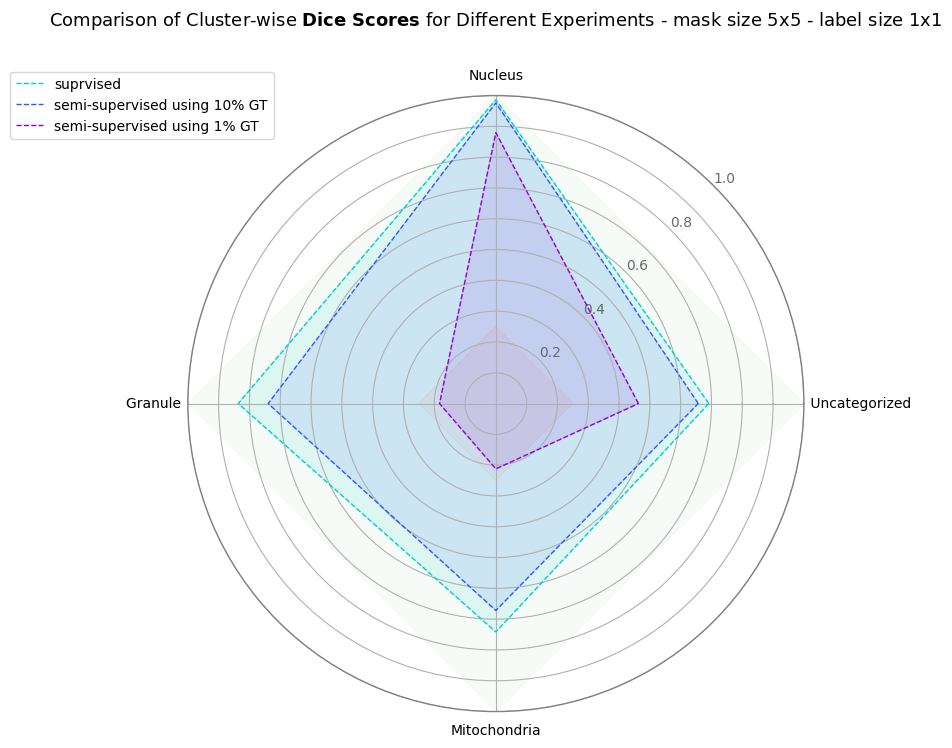

In [97]:
experiments_data = [
[0.691437802907916, 0.98635477582846, 0.8365180467091295, 0.7415730337078652],
[0.6572237960339944, 0.9763779527559056, 0.7392290249433107, 0.6717557251908397],
[0.46296296296296297, 0.8796498905908097, 0.18285714285714286, 0.21220159151193635],
]
experiment_labels = ['suprvised', 'semi-supervised using 10% GT', 'semi-supervised using 1% GT']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 5x5 - label size 1x1')


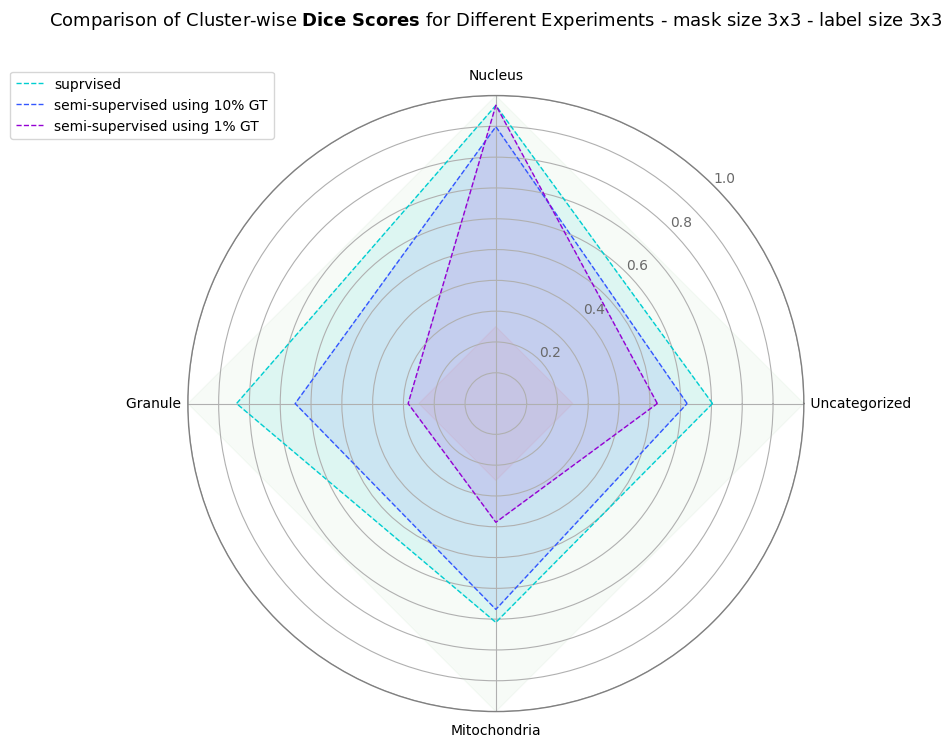

In [100]:
experiments_data = [
[0.7034277198211625, 0.9678714859437751, 0.8418803418803419, 0.7104622871046229],
[0.6210392902408112, 0.8989247311827957, 0.6516290726817042, 0.6683544303797468],
[0.5242937853107345, 0.968503937007874, 0.2848297213622291, 0.3855421686746988],
]
experiment_labels = ['suprvised', 'semi-supervised using 10% GT', 'semi-supervised using 1% GT']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 3x3 - label size 3x3')


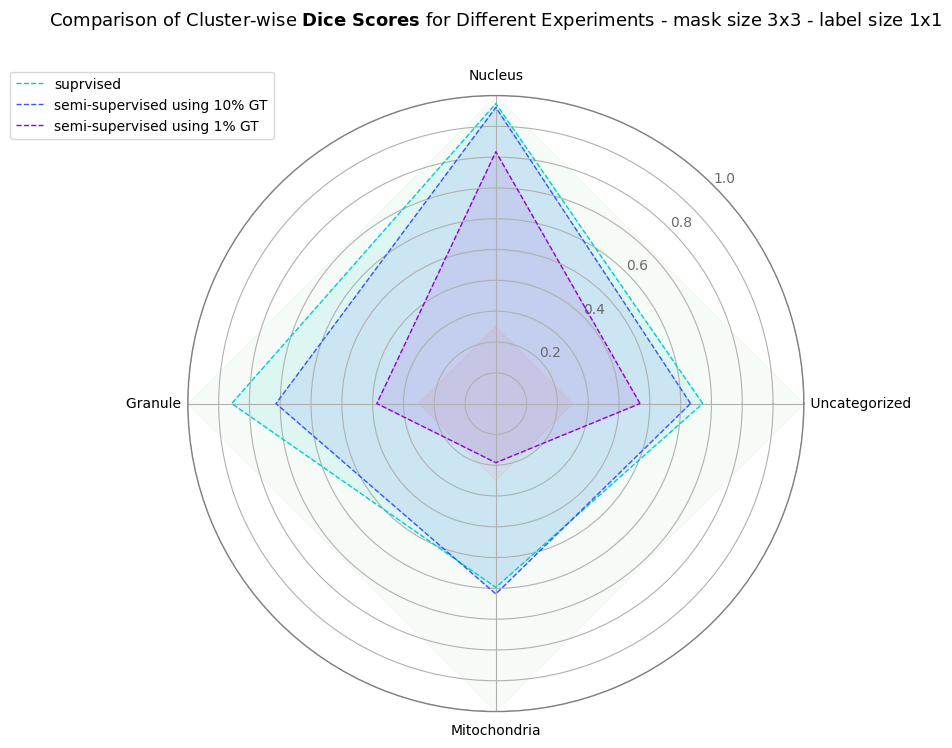

In [101]:
experiments_data = [
[0.6715542521994134, 0.9739478957915831, 0.8577319587628865, 0.5968586387434555],
[0.6321525885558583, 0.9614604462474645, 0.7139479905437353, 0.6180904522613065],
[0.4681372549019608, 0.8175519630484989, 0.3865168539325843, 0.192090395480226],
]
experiment_labels = ['suprvised', 'semi-supervised using 10% GT', 'semi-supervised using 1% GT']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 3x3 - label size 1x1')


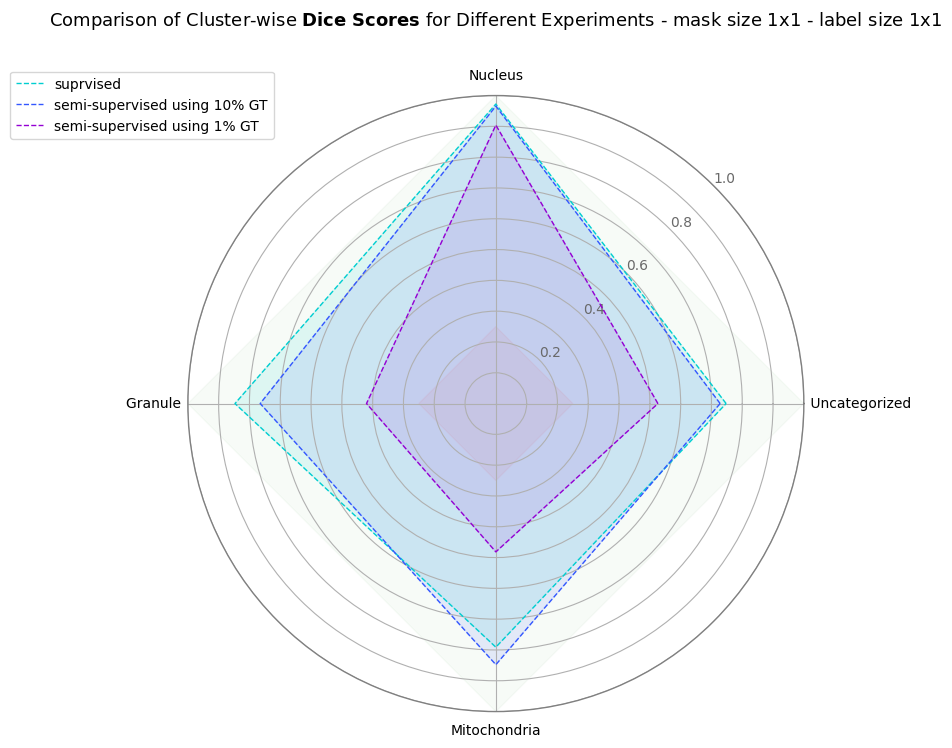

In [102]:
experiments_data = [
[0.7475728155339806, 0.9724409448818898, 0.8469601677148847, 0.7910112359550562],
[0.7281553398058253, 0.96579476861167, 0.7651006711409396, 0.8477366255144033],
[0.5261744966442953, 0.9040511727078892, 0.41995841995842, 0.48158640226628896],
]
experiment_labels = ['suprvised', f'semi-supervised using 10% GT', f'semi-supervised using 1% GT']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 1x1 - label size 1x1')


In [108]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['KL for CL']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+"test/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version supervised {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}test/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised KL for CL


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.41it/s]


In [109]:
seg_test = []
for i in range(len(model_versions)):
    seg_test.append(tiff.imread(f"{model_dir}test/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(seg_test[i][j]))

{0: 1, 1: 8, 2: 15, 3: 232}
{0: 250, 3: 6}
{1: 2, 2: 198, 3: 56}
{1: 217, 2: 2, 3: 37}


In [110]:
for i in range(len(seg_test)):
    dice_scores = compute_dice_coefficient(gt, seg_test[i])
    print(f"Model version supervised {model_versions[i]}:")
    print(dice_scores)

Model version supervised KL for CL:
[0.7904599659284497, 0.9861932938856016, 0.8407643312101911, 0.8985507246376812]


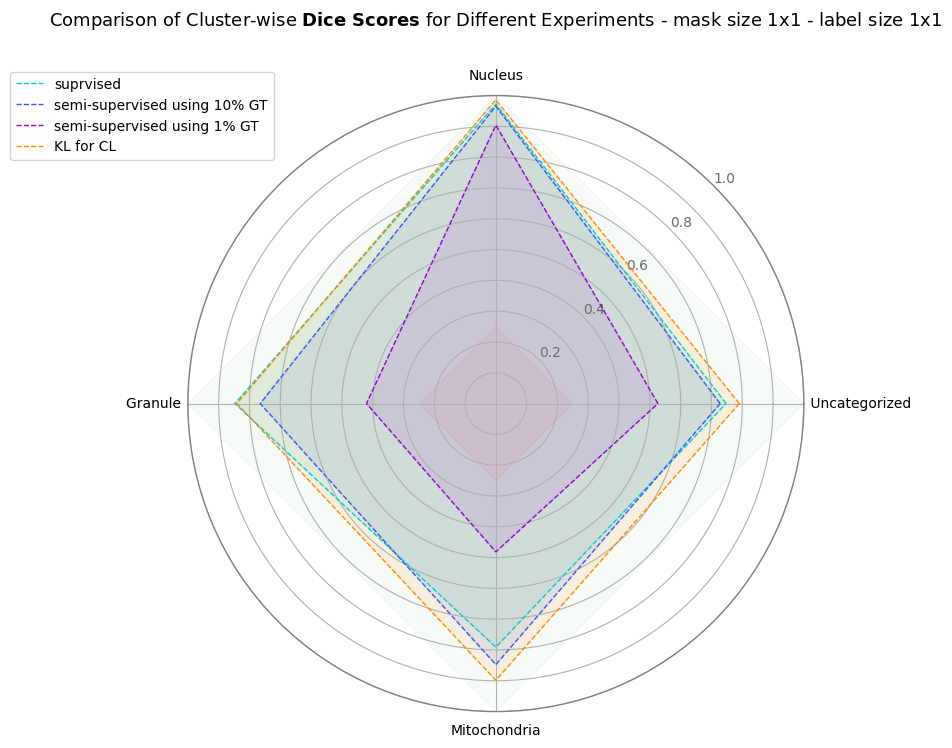

In [111]:
experiments_data = [
[0.7475728155339806, 0.9724409448818898, 0.8469601677148847, 0.7910112359550562],
[0.7281553398058253, 0.96579476861167, 0.7651006711409396, 0.8477366255144033],
[0.5261744966442953, 0.9040511727078892, 0.41995841995842, 0.48158640226628896],
[0.7904599659284497, 0.9861932938856016, 0.8407643312101911, 0.8985507246376812]
]
experiment_labels = ['suprvised', 'semi-supervised using 10% GT', 'semi-supervised using 1% GT', 'KL for CL']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'mask size 1x1 - label size 1x1')

In [113]:
model_dir = "/group/jug/Sheida/HVAE/2D/"
model_versions = ['supervised_1x1_with_5x5_data']
batch_size = 128
for model_v in model_versions:
    model = torch.load(model_dir+model_v+"/model/2D_HVAE_best_vae.net")
    data_mean = model.data_mean
    data_std = model.data_std
    model.mode_pred = True
    model.eval()
    device = model.device
    print(f"Processing 1024 pixels with model version {model_v}")
    index = 0 
    all_mus = np.zeros((1024, 43008), dtype=np.float16)
    with torch.no_grad():
        for batch in tqdm(combined_tensor):
            batch = batch.to(device)
            batch = (batch - data_mean) / data_std
            output = model(batch)
            mu_test = torch.cat([output["mu"][i].reshape(batch_size, -1) for i in range(hierarchy_level)], dim=1)
            mu_test = np.array(mu_test.cpu().numpy())
            all_mus[index:index+batch_size] = mu_test
            index += batch_size

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_mus)
    cluster_labels = cluster_labels.reshape(4, 256)
    tiff.imwrite(f"{model_dir}{model_v}/1000pixels.tif", cluster_labels)

Processing 1024 pixels with model version supervised_1x1_with_5x5_data


  0%|          | 0/8 [00:00<?, ?it/s]/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sheida.rahnamai/miniconda3/envs/emseg/lib/python3.12/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 8/8 [00:01<00:00,  5.36it/s]


In [114]:
seg_less_data = []
for i in range(len(model_versions)):
    seg_less_data.append(tiff.imread(f"{model_dir}{model_versions[i]}/1000pixels.tif"))
    for j in range(4):
        print(count_label_pixels(seg_less_data[i][j]))

{1: 241, 2: 9, 3: 6}
{0: 244, 1: 12}
{1: 75, 2: 179, 3: 2}
{0: 1, 1: 71, 2: 6, 3: 178}


In [115]:
for i in range(len(seg_less_data)):
    dice_scores = compute_dice_coefficient(gt, seg_less_data[i])
    print(f"Model version supervised {model_versions[i]}:")
    print(dice_scores)

Model version supervised supervised_1x1_with_5x5_data:
[0.7358778625954199, 0.9740518962075848, 0.7955555555555556, 0.8054298642533937]


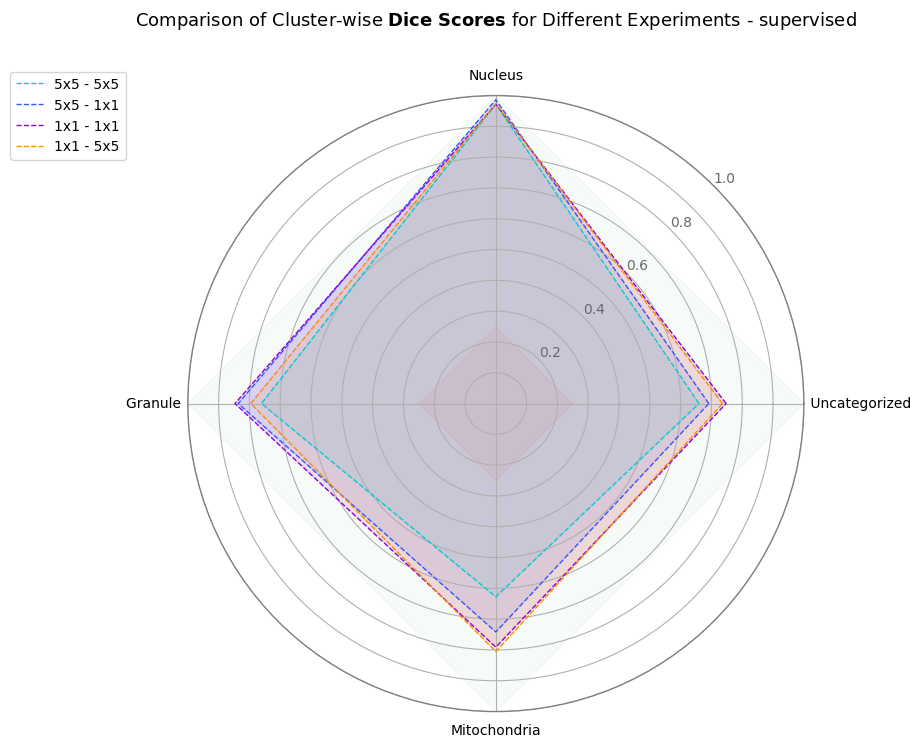

In [119]:
experiments_data = [
[0.6594885598923284, 0.9718875502008032, 0.7610208816705336, 0.6276595744680851],
[0.691437802907916, 0.98635477582846, 0.8365180467091295, 0.7415730337078652],
[0.7475728155339806, 0.9724409448818898, 0.8469601677148847, 0.7910112359550562],
[0.7358778625954199, 0.9740518962075848, 0.7955555555555556, 0.8054298642533937]
]
experiment_labels = ['5x5 - 5x5', '5x5 - 1x1', '1x1 - 1x1', '1x1 - 5x5']

# Create the radar chart
radar_chart(experiments_data, experiment_labels, 'supervised')